# Customer Churn Prediction

## Importing libraries

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from tensorflow import keras
from sklearn.metrics import classification_report
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import (GradientBoostingClassifier,
                             RandomForestClassifier,
                             BaggingClassifier)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


### Loading the data

In [3]:
df = pd.read_excel('customer_churn_large_dataset.xlsx')
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [4]:
df.shape

(100000, 9)

### Removing unwanted columns

In [5]:
df.drop(['CustomerID','Name'],axis = 1, inplace = True)
df.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0
2,24,Female,Los Angeles,5,85.47,460,0
3,36,Female,Miami,3,97.94,297,1
4,46,Female,Miami,19,58.14,266,0


### Looking for Null Values

In [6]:
df.columns = ['Age','Gender', 'Location', 'Tenure', 'Monthly_Bill', 'GB_Used', 'Churn']

In [7]:
df.isna().sum()

Age             0
Gender          0
Location        0
Tenure          0
Monthly_Bill    0
GB_Used         0
Churn           0
dtype: int64

In [8]:
(df == 0).sum()

Age                 0
Gender              0
Location            0
Tenure              0
Monthly_Bill        0
GB_Used             0
Churn           50221
dtype: int64

### Checking for Outliers

<Axes: >

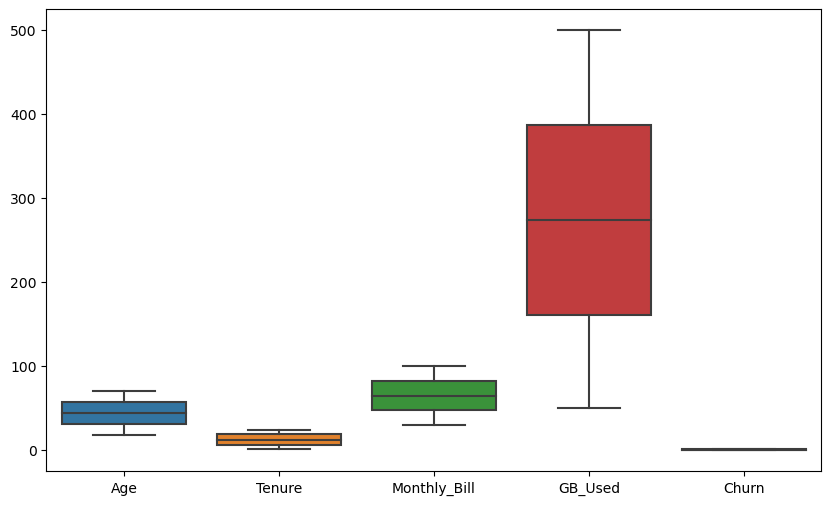

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(df)

In [10]:
df.describe()

,Age,Tenure,Monthly_Bill,GB_Used,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,44.027020,12.490100,65.053197,274.393650,0.497790
std,15.280283,6.926461,20.230696,130.463063,0.499998
min,18.000000,1.000000,30.000000,50.000000,0.000000
25%,31.000000,6.000000,47.540000,161.000000,0.000000
50%,44.000000,12.000000,65.010000,274.000000,0.000000
75%,57.000000,19.000000,82.640000,387.000000,1.000000
max,70.000000,24.000000,100.000000,500.000000,1.000000


### Data Exploration

<Axes: xlabel='Churn', ylabel='count'>

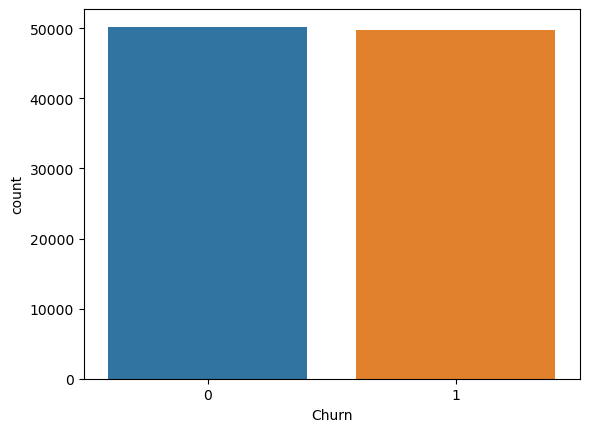

In [11]:
sns.countplot(data=df,x='Churn')

In [12]:
group = df.groupby(['Tenure']).agg('count')

In [13]:
no_churn = df[df['Churn'] == 0].Tenure
yes_churn = df[df['Churn'] == 1].Tenure

Text(0, 0.5, 'No. of Customers')

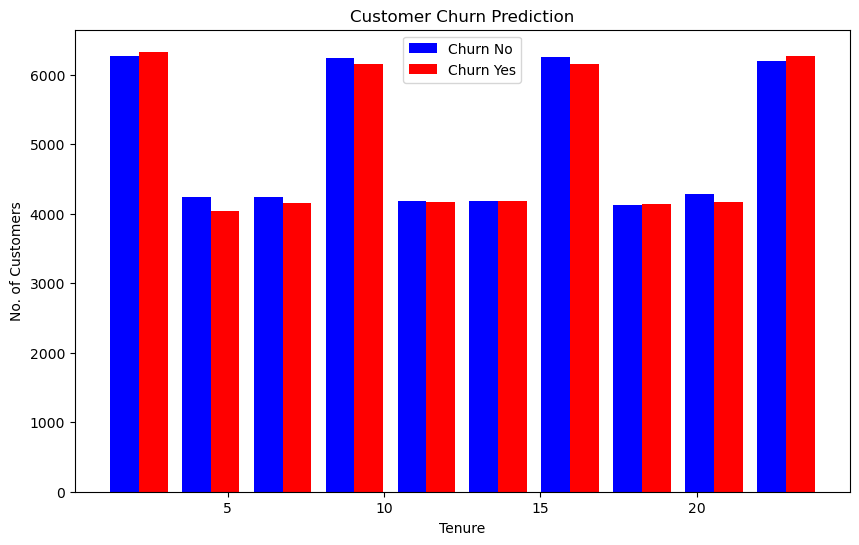

In [14]:
plt.figure(figsize=(10,6))
plt.hist([no_churn,yes_churn],color=['blue','red'])
plt.legend(labels=['Churn No','Churn Yes'])
plt.title('Customer Churn Prediction')
plt.xlabel('Tenure')
plt.ylabel('No. of Customers')

In [15]:
no_churn_monthly = df[df['Churn']==0].Monthly_Bill
yes_churn_monthly = df[df['Churn']==1].Monthly_Bill

Text(0, 0.5, 'No. of Customers')

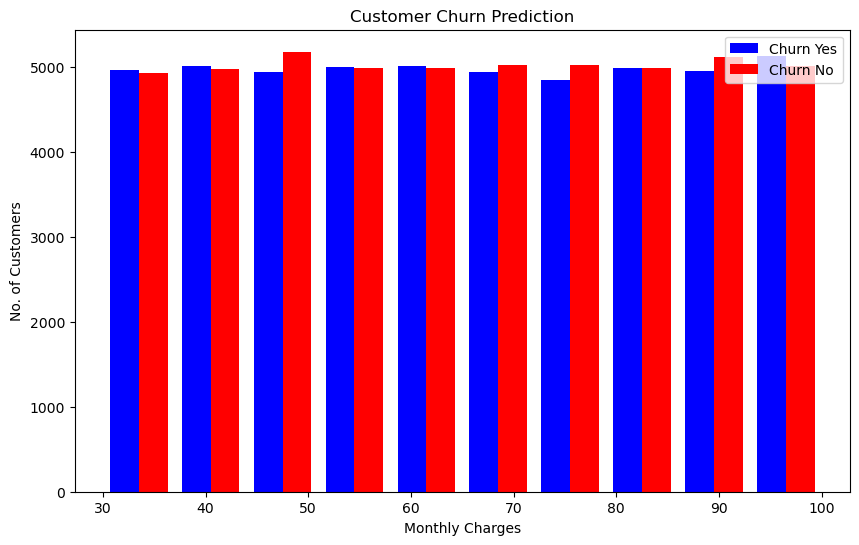

In [16]:
plt.figure(figsize=(10,6))
plt.hist([yes_churn_monthly,no_churn_monthly],color=['blue','red'])
plt.legend(labels=['Churn Yes','Churn No'])
plt.title('Customer Churn Prediction')
plt.xlabel('Monthly Charges')
plt.ylabel('No. of Customers')

### Feature Engineering

In [17]:
df.Age.describe()

count    100000.000000
mean         44.027020
std          15.280283
min          18.000000
25%          31.000000
50%          44.000000
75%          57.000000
max          70.000000
Name: Age, dtype: float64

In [18]:
bins = np.linspace(min(df.Age),max(df.Age),4)

In [19]:
group_name = ['Young','Middle_Aged','Elder']

In [20]:
df['Age_Group'] = pd.cut(df.Age,bins,labels=group_name, include_lowest=True)

In [21]:
df.head()

,Age,Gender,Location,Tenure,Monthly_Bill,GB_Used,Churn,Age_Group
0,63,Male,Los Angeles,17,73.36,236,0,Elder
1,62,Female,New York,1,48.76,172,0,Elder
2,24,Female,Los Angeles,5,85.47,460,0,Young
3,36,Female,Miami,3,97.94,297,1,Middle_Aged
4,46,Female,Miami,19,58.14,266,0,Middle_Aged


<Axes: xlabel='Age_Group', ylabel='count'>

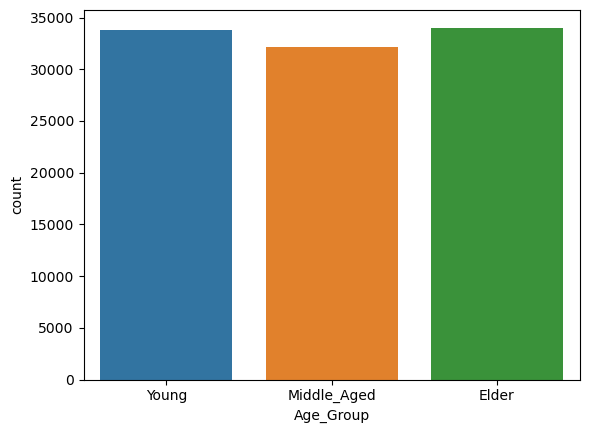

In [223]:
sns.countplot(x='Age_Group', data=df)

### Converting labled data to dummies

In [22]:
df.replace({'Male':1,'Female':0},inplace=True)
df.head()

,Age,Gender,Location,Tenure,Monthly_Bill,GB_Used,Churn,Age_Group
0,63,1,Los Angeles,17,73.36,236,0,Elder
1,62,0,New York,1,48.76,172,0,Elder
2,24,0,Los Angeles,5,85.47,460,0,Young
3,36,0,Miami,3,97.94,297,1,Middle_Aged
4,46,0,Miami,19,58.14,266,0,Middle_Aged


In [23]:
df.Location.unique()

array(['Los Angeles', 'New York', 'Miami', 'Chicago', 'Houston'],
      dtype=object)

In [24]:
categorical = df[['Location','Age_Group']]
dummies = pd.get_dummies(categorical,drop_first=True, prefix_sep='', prefix='')
dummies.head()

,Houston,Los Angeles,Miami,New York,Middle_Aged,Elder
0,0,1,0,0,0,1
1,0,0,0,1,0,1
2,0,1,0,0,0,0
3,0,0,1,0,1,0
4,0,0,1,0,1,0


In [25]:
df1 = pd.concat([df,dummies], axis='columns')
df1.head()

,Age,Gender,Location,Tenure,Monthly_Bill,GB_Used,Churn,Age_Group,Houston,Los Angeles,Miami,New York,Middle_Aged,Elder
0,63,1,Los Angeles,17,73.36,236,0,Elder,0,1,0,0,0,1
1,62,0,New York,1,48.76,172,0,Elder,0,0,0,1,0,1
2,24,0,Los Angeles,5,85.47,460,0,Young,0,1,0,0,0,0
3,36,0,Miami,3,97.94,297,1,Middle_Aged,0,0,1,0,1,0
4,46,0,Miami,19,58.14,266,0,Middle_Aged,0,0,1,0,1,0


In [26]:
df1.drop(['Location','Age_Group'], axis = 1, inplace=True)
df1.head()

,Age,Gender,Tenure,Monthly_Bill,GB_Used,Churn,Houston,Los Angeles,Miami,New York,Middle_Aged,Elder
0,63,1,17,73.36,236,0,0,1,0,0,0,1
1,62,0,1,48.76,172,0,0,0,0,1,0,1
2,24,0,5,85.47,460,0,0,1,0,0,0,0
3,36,0,3,97.94,297,1,0,0,1,0,1,0
4,46,0,19,58.14,266,0,0,0,1,0,1,0


### Scaling the data

In [27]:
df1.columns

Index(['Age', 'Gender', 'Tenure', 'Monthly_Bill', 'GB_Used', 'Churn',
       'Houston', 'Los Angeles', 'Miami', 'New York', 'Middle_Aged', 'Elder'],
      dtype='object')

In [28]:
scaler = MinMaxScaler()

In [29]:
columns_scale = ['Age', 'Tenure', 'Monthly_Bill', 'GB_Used']
for columns in columns_scale:
    df1[columns] = scaler.fit_transform(df1[[columns]])

In [30]:
df1.head()

,Age,Gender,Tenure,Monthly_Bill,GB_Used,Churn,Houston,Los Angeles,Miami,New York,Middle_Aged,Elder
0,0.865385,1,0.695652,0.619429,0.413333,0,0,1,0,0,0,1
1,0.846154,0,0.000000,0.268000,0.271111,0,0,0,0,1,0,1
2,0.115385,0,0.173913,0.792429,0.911111,0,0,1,0,0,0,0
3,0.346154,0,0.086957,0.970571,0.548889,1,0,0,1,0,1,0
4,0.538462,0,0.782609,0.402000,0.480000,0,0,0,1,0,1,0


In [184]:
X = df1.drop(['Churn'],axis = 1,)
y = df1['Churn']

In [32]:
X.head()

,Age,Gender,Tenure,Monthly_Bill,GB_Used,Houston,Los Angeles,Miami,New York,Middle_Aged,Elder
0,0.865385,1,0.695652,0.619429,0.413333,0,1,0,0,0,1
1,0.846154,0,0.000000,0.268000,0.271111,0,0,0,1,0,1
2,0.115385,0,0.173913,0.792429,0.911111,0,1,0,0,0,0
3,0.346154,0,0.086957,0.970571,0.548889,0,0,1,0,1,0
4,0.538462,0,0.782609,0.402000,0.480000,0,0,1,0,1,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

80000
20000
80000
20000


### Fitting the models

In [35]:
X1_train.head()

NameError: name 'X1_train' is not defined

In [37]:
models = []

models.append(('Decision Tree',DecisionTreeClassifier(random_state=1,max_depth=20)))
models.append(('Logistic Regression', LogisticRegression(random_state=1)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=50,random_state=1,max_depth=15)))
models.append(('Gradient Boositing', GradientBoostingClassifier(random_state=1)))
models.append(('Bagging Classifier', BaggingClassifier(random_state=1)))


for name, model in models:
    model.fit(X_train,y_train)
    train_result = model.score(X_train,y_train)
    test_result = model.score(X_test,y_test)
    print('{} : Train score {}, Test score {}'.format(name,train_result,test_result))

Decision Tree : Train score 0.670525, Test score 0.4957
Logistic Regression : Train score 0.5047625, Test score 0.50085
Random Forest : Train score 0.885775, Test score 0.4989
Gradient Boositing : Train score 0.5380125, Test score 0.5
Bagging Classifier : Train score 0.982325, Test score 0.50445


In [38]:
xgb = XGBClassifier(n_estimators = 10000,
                    early_stopping_rounds = 1000,
                    learning_rate = 0.01)
xgb.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)], verbose=50)

[0]	validation_0-logloss:0.69311	validation_1-logloss:0.69315
[50]	validation_0-logloss:0.69146	validation_1-logloss:0.69319
[100]	validation_0-logloss:0.69006	validation_1-logloss:0.69326
[150]	validation_0-logloss:0.68879	validation_1-logloss:0.69340
[200]	validation_0-logloss:0.68767	validation_1-logloss:0.69350
[250]	validation_0-logloss:0.68660	validation_1-logloss:0.69360
[300]	validation_0-logloss:0.68564	validation_1-logloss:0.69375
[350]	validation_0-logloss:0.68479	validation_1-logloss:0.69385
[400]	validation_0-logloss:0.68383	validation_1-logloss:0.69401
[450]	validation_0-logloss:0.68298	validation_1-logloss:0.69421
[500]	validation_0-logloss:0.68209	validation_1-logloss:0.69436
[550]	validation_0-logloss:0.68111	validation_1-logloss:0.69444
[600]	validation_0-logloss:0.68027	validation_1-logloss:0.69457
[650]	validation_0-logloss:0.67951	validation_1-logloss:0.69467
[700]	validation_0-logloss:0.67871	validation_1-logloss:0.69476
[750]	validation_0-logloss:0.67790	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=1000,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [39]:
print(xgb.score(X_train,y_train))
print(xgb.score(X_test,y_test))

0.5181625
0.4995


In [67]:
nn_model = keras.Sequential([
    keras.layers.Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
nn_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.1)

Epoch 1/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 2/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 3/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 4/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 5/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 6/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 7/25
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy:

In [227]:
loss, accuracy = nn_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

y_pred = nn_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary))


625/625 [==============================] - 0s 598us/step - loss: 0.6931 - accuracy: 0.5039
Test accuracy: 0.5039499998092651
625/625 [==============================] - 0s 477us/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10079
           1       0.00      0.00      0.00      9921

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.34     20000
weighted avg       0.25      0.50      0.34     20000



### Hyper parameter tuning 

In [82]:
param_dist = {
    'max_depth': [20,30,40,50,70],
    'learning_rate': [0.1,0.01,0.001,0.0001],
    'subsample': [0.5,0.10,0.20],
    'early_stopping_rounds' :[20,50,100,200],
    'n_estimators': [100,200,500,700]}

In [83]:
grid_serch = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, scoring='accuracy', cv=5, verbose=50, error_score='raise')
grid_serch.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)])


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START early_stopping_rounds=100, learning_rate=0.0001, max_depth=70, n_estimators=700, subsample=0.5
[0]	validation_0-logloss:0.69313	validation_1-logloss:0.69315
[1]	validation_0-logloss:0.69312	validation_1-logloss:0.69315
[2]	validation_0-logloss:0.69311	validation_1-logloss:0.69315
[3]	validation_0-logloss:0.69309	validation_1-logloss:0.69315
[4]	validation_0-logloss:0.69308	validation_1-logloss:0.69315
[5]	validation_0-logloss:0.69306	validation_1-logloss:0.69315
[6]	validation_0-logloss:0.69305	validation_1-logloss:0.69315
[7]	validation_0-logloss:0.69304	validation_1-logloss:0.69315
[8]	validation_0-logloss:0.69303	validation_1-logloss:0.69315
[9]	validation_0-logloss:0.69301	validation_1-logloss:0.69315
[10]	validation_0-logloss:0.69300	validation_1-logloss:0.69315
[11]	validation_0-logloss:0.69299	validation_1-logloss:0.69315
[12]	validation_0-logloss:0.69297	validation_1-logloss:0.69315
[13]	validatio

[127]	validation_0-logloss:0.69152	validation_1-logloss:0.69315
[128]	validation_0-logloss:0.69151	validation_1-logloss:0.69315
[129]	validation_0-logloss:0.69150	validation_1-logloss:0.69315
[130]	validation_0-logloss:0.69149	validation_1-logloss:0.69315
[131]	validation_0-logloss:0.69147	validation_1-logloss:0.69315
[132]	validation_0-logloss:0.69146	validation_1-logloss:0.69315
[133]	validation_0-logloss:0.69145	validation_1-logloss:0.69315
[134]	validation_0-logloss:0.69144	validation_1-logloss:0.69315
[135]	validation_0-logloss:0.69142	validation_1-logloss:0.69315
[136]	validation_0-logloss:0.69141	validation_1-logloss:0.69315
[137]	validation_0-logloss:0.69140	validation_1-logloss:0.69315
[138]	validation_0-logloss:0.69139	validation_1-logloss:0.69315
[139]	validation_0-logloss:0.69137	validation_1-logloss:0.69315
[140]	validation_0-logloss:0.69136	validation_1-logloss:0.69315
[141]	validation_0-logloss:0.69135	validation_1-logloss:0.69315
[142]	validation_0-logloss:0.69133	valid

[101]	validation_0-logloss:0.69185	validation_1-logloss:0.69314
[102]	validation_0-logloss:0.69184	validation_1-logloss:0.69314
[103]	validation_0-logloss:0.69182	validation_1-logloss:0.69314
[104]	validation_0-logloss:0.69181	validation_1-logloss:0.69314
[105]	validation_0-logloss:0.69180	validation_1-logloss:0.69315
[106]	validation_0-logloss:0.69179	validation_1-logloss:0.69314
[107]	validation_0-logloss:0.69177	validation_1-logloss:0.69314
[108]	validation_0-logloss:0.69176	validation_1-logloss:0.69314
[109]	validation_0-logloss:0.69175	validation_1-logloss:0.69314
[110]	validation_0-logloss:0.69173	validation_1-logloss:0.69314
[111]	validation_0-logloss:0.69172	validation_1-logloss:0.69314
[112]	validation_0-logloss:0.69171	validation_1-logloss:0.69314
[113]	validation_0-logloss:0.69170	validation_1-logloss:0.69314
[114]	validation_0-logloss:0.69168	validation_1-logloss:0.69315
[115]	validation_0-logloss:0.69167	validation_1-logloss:0.69315
[116]	validation_0-logloss:0.69166	valid

[74]	validation_0-logloss:0.69219	validation_1-logloss:0.69315
[75]	validation_0-logloss:0.69217	validation_1-logloss:0.69315
[76]	validation_0-logloss:0.69216	validation_1-logloss:0.69315
[77]	validation_0-logloss:0.69215	validation_1-logloss:0.69315
[78]	validation_0-logloss:0.69214	validation_1-logloss:0.69315
[79]	validation_0-logloss:0.69212	validation_1-logloss:0.69315
[80]	validation_0-logloss:0.69211	validation_1-logloss:0.69315
[81]	validation_0-logloss:0.69210	validation_1-logloss:0.69315
[82]	validation_0-logloss:0.69209	validation_1-logloss:0.69315
[83]	validation_0-logloss:0.69207	validation_1-logloss:0.69315
[84]	validation_0-logloss:0.69206	validation_1-logloss:0.69315
[85]	validation_0-logloss:0.69205	validation_1-logloss:0.69315
[86]	validation_0-logloss:0.69204	validation_1-logloss:0.69315
[87]	validation_0-logloss:0.69202	validation_1-logloss:0.69315
[88]	validation_0-logloss:0.69201	validation_1-logloss:0.69315
[89]	validation_0-logloss:0.69200	validation_1-logloss:

[96]	validation_0-logloss:0.69191	validation_1-logloss:0.69315
[97]	validation_0-logloss:0.69190	validation_1-logloss:0.69315
[98]	validation_0-logloss:0.69188	validation_1-logloss:0.69315
[99]	validation_0-logloss:0.69187	validation_1-logloss:0.69315
[100]	validation_0-logloss:0.69186	validation_1-logloss:0.69315
[101]	validation_0-logloss:0.69185	validation_1-logloss:0.69315
[102]	validation_0-logloss:0.69183	validation_1-logloss:0.69315
[103]	validation_0-logloss:0.69182	validation_1-logloss:0.69315
[104]	validation_0-logloss:0.69181	validation_1-logloss:0.69315
[105]	validation_0-logloss:0.69180	validation_1-logloss:0.69315
[106]	validation_0-logloss:0.69178	validation_1-logloss:0.69315
[107]	validation_0-logloss:0.69177	validation_1-logloss:0.69315
[108]	validation_0-logloss:0.69176	validation_1-logloss:0.69315
[109]	validation_0-logloss:0.69175	validation_1-logloss:0.69315
[110]	validation_0-logloss:0.69173	validation_1-logloss:0.69315
[111]	validation_0-logloss:0.69172	validatio

[89]	validation_0-logloss:0.69200	validation_1-logloss:0.69314
[90]	validation_0-logloss:0.69198	validation_1-logloss:0.69314
[91]	validation_0-logloss:0.69197	validation_1-logloss:0.69315
[92]	validation_0-logloss:0.69196	validation_1-logloss:0.69314
[93]	validation_0-logloss:0.69194	validation_1-logloss:0.69314
[94]	validation_0-logloss:0.69193	validation_1-logloss:0.69315
[95]	validation_0-logloss:0.69192	validation_1-logloss:0.69315
[96]	validation_0-logloss:0.69191	validation_1-logloss:0.69315
[97]	validation_0-logloss:0.69189	validation_1-logloss:0.69315
[98]	validation_0-logloss:0.69188	validation_1-logloss:0.69315
[99]	validation_0-logloss:0.69187	validation_1-logloss:0.69315
[100]	validation_0-logloss:0.69186	validation_1-logloss:0.69315
[101]	validation_0-logloss:0.69184	validation_1-logloss:0.69315
[102]	validation_0-logloss:0.69183	validation_1-logloss:0.69315
[103]	validation_0-logloss:0.69182	validation_1-logloss:0.69315
[104]	validation_0-logloss:0.69181	validation_1-log

[23]	validation_0-logloss:0.69192	validation_1-logloss:0.69315
[24]	validation_0-logloss:0.69187	validation_1-logloss:0.69315
[25]	validation_0-logloss:0.69182	validation_1-logloss:0.69315
[26]	validation_0-logloss:0.69177	validation_1-logloss:0.69316
[27]	validation_0-logloss:0.69172	validation_1-logloss:0.69316
[28]	validation_0-logloss:0.69167	validation_1-logloss:0.69316
[29]	validation_0-logloss:0.69162	validation_1-logloss:0.69316
[30]	validation_0-logloss:0.69156	validation_1-logloss:0.69316
[31]	validation_0-logloss:0.69151	validation_1-logloss:0.69316
[32]	validation_0-logloss:0.69146	validation_1-logloss:0.69316
[33]	validation_0-logloss:0.69141	validation_1-logloss:0.69315
[34]	validation_0-logloss:0.69136	validation_1-logloss:0.69315
[35]	validation_0-logloss:0.69131	validation_1-logloss:0.69315
[36]	validation_0-logloss:0.69126	validation_1-logloss:0.69315
[37]	validation_0-logloss:0.69121	validation_1-logloss:0.69314
[38]	validation_0-logloss:0.69115	validation_1-logloss:

[153]	validation_0-logloss:0.68543	validation_1-logloss:0.69318
[154]	validation_0-logloss:0.68538	validation_1-logloss:0.69318
[155]	validation_0-logloss:0.68533	validation_1-logloss:0.69318
[156]	validation_0-logloss:0.68528	validation_1-logloss:0.69319
[157]	validation_0-logloss:0.68523	validation_1-logloss:0.69318
[158]	validation_0-logloss:0.68518	validation_1-logloss:0.69318
[159]	validation_0-logloss:0.68514	validation_1-logloss:0.69318
[160]	validation_0-logloss:0.68508	validation_1-logloss:0.69318
[161]	validation_0-logloss:0.68504	validation_1-logloss:0.69318
[162]	validation_0-logloss:0.68499	validation_1-logloss:0.69318
[163]	validation_0-logloss:0.68494	validation_1-logloss:0.69318
[164]	validation_0-logloss:0.68489	validation_1-logloss:0.69318
[CV 1/5; 2/10] END early_stopping_rounds=100, learning_rate=0.001, max_depth=70, n_estimators=200, subsample=0.2;, score=0.503 total time=  14.2s
[CV 2/5; 2/10] START early_stopping_rounds=100, learning_rate=0.001, max_depth=70, n_e

[114]	validation_0-logloss:0.68734	validation_1-logloss:0.69314
[115]	validation_0-logloss:0.68729	validation_1-logloss:0.69314
[116]	validation_0-logloss:0.68723	validation_1-logloss:0.69314
[117]	validation_0-logloss:0.68719	validation_1-logloss:0.69314
[118]	validation_0-logloss:0.68714	validation_1-logloss:0.69314
[119]	validation_0-logloss:0.68709	validation_1-logloss:0.69314
[120]	validation_0-logloss:0.68704	validation_1-logloss:0.69315
[121]	validation_0-logloss:0.68699	validation_1-logloss:0.69315
[122]	validation_0-logloss:0.68694	validation_1-logloss:0.69315
[123]	validation_0-logloss:0.68689	validation_1-logloss:0.69315
[124]	validation_0-logloss:0.68684	validation_1-logloss:0.69315
[125]	validation_0-logloss:0.68679	validation_1-logloss:0.69314
[126]	validation_0-logloss:0.68674	validation_1-logloss:0.69314
[127]	validation_0-logloss:0.68669	validation_1-logloss:0.69314
[128]	validation_0-logloss:0.68664	validation_1-logloss:0.69314
[129]	validation_0-logloss:0.68659	valid

[102]	validation_0-logloss:0.68792	validation_1-logloss:0.69323
[103]	validation_0-logloss:0.68787	validation_1-logloss:0.69323
[104]	validation_0-logloss:0.68782	validation_1-logloss:0.69324
[105]	validation_0-logloss:0.68777	validation_1-logloss:0.69323
[106]	validation_0-logloss:0.68772	validation_1-logloss:0.69323
[107]	validation_0-logloss:0.68767	validation_1-logloss:0.69323
[108]	validation_0-logloss:0.68762	validation_1-logloss:0.69323
[109]	validation_0-logloss:0.68757	validation_1-logloss:0.69323
[110]	validation_0-logloss:0.68752	validation_1-logloss:0.69323
[111]	validation_0-logloss:0.68747	validation_1-logloss:0.69324
[112]	validation_0-logloss:0.68742	validation_1-logloss:0.69323
[113]	validation_0-logloss:0.68737	validation_1-logloss:0.69323
[114]	validation_0-logloss:0.68732	validation_1-logloss:0.69323
[115]	validation_0-logloss:0.68727	validation_1-logloss:0.69324
[116]	validation_0-logloss:0.68722	validation_1-logloss:0.69323
[117]	validation_0-logloss:0.68717	valid

[107]	validation_0-logloss:0.68769	validation_1-logloss:0.69316
[108]	validation_0-logloss:0.68765	validation_1-logloss:0.69316
[109]	validation_0-logloss:0.68760	validation_1-logloss:0.69317
[110]	validation_0-logloss:0.68755	validation_1-logloss:0.69317
[111]	validation_0-logloss:0.68750	validation_1-logloss:0.69318
[112]	validation_0-logloss:0.68745	validation_1-logloss:0.69318
[113]	validation_0-logloss:0.68740	validation_1-logloss:0.69317
[114]	validation_0-logloss:0.68735	validation_1-logloss:0.69317
[115]	validation_0-logloss:0.68730	validation_1-logloss:0.69317
[116]	validation_0-logloss:0.68725	validation_1-logloss:0.69317
[117]	validation_0-logloss:0.68720	validation_1-logloss:0.69317
[118]	validation_0-logloss:0.68715	validation_1-logloss:0.69316
[119]	validation_0-logloss:0.68711	validation_1-logloss:0.69317
[120]	validation_0-logloss:0.68706	validation_1-logloss:0.69317
[121]	validation_0-logloss:0.68701	validation_1-logloss:0.69317
[122]	validation_0-logloss:0.68696	valid

[102]	validation_0-logloss:0.68795	validation_1-logloss:0.69318
[103]	validation_0-logloss:0.68790	validation_1-logloss:0.69318
[104]	validation_0-logloss:0.68786	validation_1-logloss:0.69318
[105]	validation_0-logloss:0.68781	validation_1-logloss:0.69319
[106]	validation_0-logloss:0.68776	validation_1-logloss:0.69318
[107]	validation_0-logloss:0.68771	validation_1-logloss:0.69318
[108]	validation_0-logloss:0.68765	validation_1-logloss:0.69318
[109]	validation_0-logloss:0.68760	validation_1-logloss:0.69318
[110]	validation_0-logloss:0.68756	validation_1-logloss:0.69318
[111]	validation_0-logloss:0.68751	validation_1-logloss:0.69319
[112]	validation_0-logloss:0.68746	validation_1-logloss:0.69318
[113]	validation_0-logloss:0.68741	validation_1-logloss:0.69319
[114]	validation_0-logloss:0.68736	validation_1-logloss:0.69318
[115]	validation_0-logloss:0.68731	validation_1-logloss:0.69318
[116]	validation_0-logloss:0.68726	validation_1-logloss:0.69319
[117]	validation_0-logloss:0.68722	valid

[0]	validation_0-logloss:0.68844	validation_1-logloss:0.69451
[1]	validation_0-logloss:0.68480	validation_1-logloss:0.69561
[2]	validation_0-logloss:0.68077	validation_1-logloss:0.69702
[3]	validation_0-logloss:0.67707	validation_1-logloss:0.69843
[4]	validation_0-logloss:0.67365	validation_1-logloss:0.69934
[5]	validation_0-logloss:0.67060	validation_1-logloss:0.70055
[6]	validation_0-logloss:0.66689	validation_1-logloss:0.70193
[7]	validation_0-logloss:0.66353	validation_1-logloss:0.70345
[8]	validation_0-logloss:0.66036	validation_1-logloss:0.70437
[9]	validation_0-logloss:0.65708	validation_1-logloss:0.70607
[10]	validation_0-logloss:0.65445	validation_1-logloss:0.70743
[11]	validation_0-logloss:0.65147	validation_1-logloss:0.70848
[12]	validation_0-logloss:0.64839	validation_1-logloss:0.70982
[13]	validation_0-logloss:0.64605	validation_1-logloss:0.71053
[14]	validation_0-logloss:0.64310	validation_1-logloss:0.71180
[15]	validation_0-logloss:0.64040	validation_1-logloss:0.71302
[1

[107]	validation_0-logloss:0.69184	validation_1-logloss:0.69315
[108]	validation_0-logloss:0.69183	validation_1-logloss:0.69315
[109]	validation_0-logloss:0.69182	validation_1-logloss:0.69315
[110]	validation_0-logloss:0.69181	validation_1-logloss:0.69315
[111]	validation_0-logloss:0.69180	validation_1-logloss:0.69315
[112]	validation_0-logloss:0.69178	validation_1-logloss:0.69315
[113]	validation_0-logloss:0.69177	validation_1-logloss:0.69315
[114]	validation_0-logloss:0.69176	validation_1-logloss:0.69315
[115]	validation_0-logloss:0.69175	validation_1-logloss:0.69315
[116]	validation_0-logloss:0.69174	validation_1-logloss:0.69315
[117]	validation_0-logloss:0.69173	validation_1-logloss:0.69315
[118]	validation_0-logloss:0.69172	validation_1-logloss:0.69315
[119]	validation_0-logloss:0.69171	validation_1-logloss:0.69315
[120]	validation_0-logloss:0.69169	validation_1-logloss:0.69315
[121]	validation_0-logloss:0.69168	validation_1-logloss:0.69315
[122]	validation_0-logloss:0.69167	valid

[32]	validation_0-logloss:0.69276	validation_1-logloss:0.69314
[33]	validation_0-logloss:0.69275	validation_1-logloss:0.69314
[34]	validation_0-logloss:0.69273	validation_1-logloss:0.69314
[35]	validation_0-logloss:0.69272	validation_1-logloss:0.69314
[36]	validation_0-logloss:0.69271	validation_1-logloss:0.69314
[37]	validation_0-logloss:0.69270	validation_1-logloss:0.69314
[38]	validation_0-logloss:0.69269	validation_1-logloss:0.69314
[39]	validation_0-logloss:0.69268	validation_1-logloss:0.69314
[40]	validation_0-logloss:0.69266	validation_1-logloss:0.69314
[41]	validation_0-logloss:0.69265	validation_1-logloss:0.69314
[42]	validation_0-logloss:0.69264	validation_1-logloss:0.69314
[43]	validation_0-logloss:0.69263	validation_1-logloss:0.69314
[44]	validation_0-logloss:0.69262	validation_1-logloss:0.69314
[45]	validation_0-logloss:0.69260	validation_1-logloss:0.69314
[46]	validation_0-logloss:0.69259	validation_1-logloss:0.69314
[47]	validation_0-logloss:0.69258	validation_1-logloss:

[162]	validation_0-logloss:0.69122	validation_1-logloss:0.69314
[163]	validation_0-logloss:0.69121	validation_1-logloss:0.69314
[164]	validation_0-logloss:0.69120	validation_1-logloss:0.69314
[165]	validation_0-logloss:0.69119	validation_1-logloss:0.69314
[166]	validation_0-logloss:0.69117	validation_1-logloss:0.69314
[167]	validation_0-logloss:0.69116	validation_1-logloss:0.69314
[168]	validation_0-logloss:0.69115	validation_1-logloss:0.69314
[169]	validation_0-logloss:0.69114	validation_1-logloss:0.69314
[170]	validation_0-logloss:0.69113	validation_1-logloss:0.69314
[171]	validation_0-logloss:0.69111	validation_1-logloss:0.69314
[172]	validation_0-logloss:0.69110	validation_1-logloss:0.69314
[173]	validation_0-logloss:0.69109	validation_1-logloss:0.69314
[174]	validation_0-logloss:0.69108	validation_1-logloss:0.69314
[175]	validation_0-logloss:0.69107	validation_1-logloss:0.69314
[176]	validation_0-logloss:0.69106	validation_1-logloss:0.69314
[177]	validation_0-logloss:0.69104	valid

[88]	validation_0-logloss:0.69207	validation_1-logloss:0.69315
[89]	validation_0-logloss:0.69206	validation_1-logloss:0.69315
[90]	validation_0-logloss:0.69205	validation_1-logloss:0.69315
[91]	validation_0-logloss:0.69203	validation_1-logloss:0.69315
[92]	validation_0-logloss:0.69202	validation_1-logloss:0.69315
[93]	validation_0-logloss:0.69201	validation_1-logloss:0.69315
[94]	validation_0-logloss:0.69200	validation_1-logloss:0.69315
[95]	validation_0-logloss:0.69199	validation_1-logloss:0.69315
[96]	validation_0-logloss:0.69197	validation_1-logloss:0.69315
[97]	validation_0-logloss:0.69196	validation_1-logloss:0.69315
[98]	validation_0-logloss:0.69195	validation_1-logloss:0.69316
[99]	validation_0-logloss:0.69194	validation_1-logloss:0.69316
[100]	validation_0-logloss:0.69193	validation_1-logloss:0.69316
[101]	validation_0-logloss:0.69192	validation_1-logloss:0.69316
[102]	validation_0-logloss:0.69191	validation_1-logloss:0.69316
[103]	validation_0-logloss:0.69189	validation_1-logl

[13]	validation_0-logloss:0.69297	validation_1-logloss:0.69315
[14]	validation_0-logloss:0.69296	validation_1-logloss:0.69315
[15]	validation_0-logloss:0.69295	validation_1-logloss:0.69315
[16]	validation_0-logloss:0.69294	validation_1-logloss:0.69315
[17]	validation_0-logloss:0.69293	validation_1-logloss:0.69315
[18]	validation_0-logloss:0.69291	validation_1-logloss:0.69315
[19]	validation_0-logloss:0.69290	validation_1-logloss:0.69315
[20]	validation_0-logloss:0.69289	validation_1-logloss:0.69315
[21]	validation_0-logloss:0.69288	validation_1-logloss:0.69315
[22]	validation_0-logloss:0.69287	validation_1-logloss:0.69315
[23]	validation_0-logloss:0.69286	validation_1-logloss:0.69315
[24]	validation_0-logloss:0.69284	validation_1-logloss:0.69315
[25]	validation_0-logloss:0.69283	validation_1-logloss:0.69315
[26]	validation_0-logloss:0.69282	validation_1-logloss:0.69315
[27]	validation_0-logloss:0.69281	validation_1-logloss:0.69315
[28]	validation_0-logloss:0.69280	validation_1-logloss:

[143]	validation_0-logloss:0.69144	validation_1-logloss:0.69315
[144]	validation_0-logloss:0.69143	validation_1-logloss:0.69315
[145]	validation_0-logloss:0.69142	validation_1-logloss:0.69315
[146]	validation_0-logloss:0.69140	validation_1-logloss:0.69315
[147]	validation_0-logloss:0.69139	validation_1-logloss:0.69315
[148]	validation_0-logloss:0.69138	validation_1-logloss:0.69315
[149]	validation_0-logloss:0.69137	validation_1-logloss:0.69315
[150]	validation_0-logloss:0.69136	validation_1-logloss:0.69315
[151]	validation_0-logloss:0.69134	validation_1-logloss:0.69315
[152]	validation_0-logloss:0.69133	validation_1-logloss:0.69315
[153]	validation_0-logloss:0.69132	validation_1-logloss:0.69315
[154]	validation_0-logloss:0.69131	validation_1-logloss:0.69315
[155]	validation_0-logloss:0.69130	validation_1-logloss:0.69315
[156]	validation_0-logloss:0.69129	validation_1-logloss:0.69315
[157]	validation_0-logloss:0.69127	validation_1-logloss:0.69315
[158]	validation_0-logloss:0.69126	valid

[69]	validation_0-logloss:0.69230	validation_1-logloss:0.69315
[70]	validation_0-logloss:0.69228	validation_1-logloss:0.69315
[71]	validation_0-logloss:0.69227	validation_1-logloss:0.69315
[72]	validation_0-logloss:0.69226	validation_1-logloss:0.69315
[73]	validation_0-logloss:0.69225	validation_1-logloss:0.69315
[74]	validation_0-logloss:0.69223	validation_1-logloss:0.69315
[75]	validation_0-logloss:0.69222	validation_1-logloss:0.69315
[76]	validation_0-logloss:0.69221	validation_1-logloss:0.69315
[77]	validation_0-logloss:0.69220	validation_1-logloss:0.69315
[78]	validation_0-logloss:0.69219	validation_1-logloss:0.69315
[79]	validation_0-logloss:0.69217	validation_1-logloss:0.69315
[80]	validation_0-logloss:0.69216	validation_1-logloss:0.69315
[81]	validation_0-logloss:0.69215	validation_1-logloss:0.69315
[82]	validation_0-logloss:0.69214	validation_1-logloss:0.69315
[83]	validation_0-logloss:0.69213	validation_1-logloss:0.69315
[84]	validation_0-logloss:0.69211	validation_1-logloss:

[198]	validation_0-logloss:0.69075	validation_1-logloss:0.69315
[199]	validation_0-logloss:0.69074	validation_1-logloss:0.69315
[CV 5/5; 4/10] END early_stopping_rounds=200, learning_rate=0.0001, max_depth=30, n_estimators=200, subsample=0.5;, score=0.507 total time=  30.7s
[CV 1/5; 5/10] START early_stopping_rounds=100, learning_rate=0.1, max_depth=40, n_estimators=100, subsample=0.1
[0]	validation_0-logloss:0.69140	validation_1-logloss:0.69401
[1]	validation_0-logloss:0.69010	validation_1-logloss:0.69556
[2]	validation_0-logloss:0.68869	validation_1-logloss:0.69699
[3]	validation_0-logloss:0.68733	validation_1-logloss:0.69819
[4]	validation_0-logloss:0.68572	validation_1-logloss:0.69959
[5]	validation_0-logloss:0.68422	validation_1-logloss:0.70060
[6]	validation_0-logloss:0.68279	validation_1-logloss:0.70190
[7]	validation_0-logloss:0.68161	validation_1-logloss:0.70292
[8]	validation_0-logloss:0.68049	validation_1-logloss:0.70387
[9]	validation_0-logloss:0.67913	validation_1-logloss:

[21]	validation_0-logloss:0.66511	validation_1-logloss:0.71503
[22]	validation_0-logloss:0.66388	validation_1-logloss:0.71629
[23]	validation_0-logloss:0.66295	validation_1-logloss:0.71728
[24]	validation_0-logloss:0.66186	validation_1-logloss:0.71799
[25]	validation_0-logloss:0.66106	validation_1-logloss:0.71845
[26]	validation_0-logloss:0.66011	validation_1-logloss:0.71942
[27]	validation_0-logloss:0.65891	validation_1-logloss:0.71973
[28]	validation_0-logloss:0.65769	validation_1-logloss:0.71998
[29]	validation_0-logloss:0.65665	validation_1-logloss:0.72124
[30]	validation_0-logloss:0.65573	validation_1-logloss:0.72195
[31]	validation_0-logloss:0.65485	validation_1-logloss:0.72400
[32]	validation_0-logloss:0.65385	validation_1-logloss:0.72468
[33]	validation_0-logloss:0.65273	validation_1-logloss:0.72571
[34]	validation_0-logloss:0.65163	validation_1-logloss:0.72643
[35]	validation_0-logloss:0.65075	validation_1-logloss:0.72699
[36]	validation_0-logloss:0.64992	validation_1-logloss:

[48]	validation_0-logloss:0.63950	validation_1-logloss:0.74694
[49]	validation_0-logloss:0.63849	validation_1-logloss:0.74779
[50]	validation_0-logloss:0.63747	validation_1-logloss:0.74899
[51]	validation_0-logloss:0.63655	validation_1-logloss:0.74920
[52]	validation_0-logloss:0.63569	validation_1-logloss:0.75025
[53]	validation_0-logloss:0.63486	validation_1-logloss:0.75207
[54]	validation_0-logloss:0.63390	validation_1-logloss:0.75333
[55]	validation_0-logloss:0.63321	validation_1-logloss:0.75431
[56]	validation_0-logloss:0.63228	validation_1-logloss:0.75551
[57]	validation_0-logloss:0.63138	validation_1-logloss:0.75627
[58]	validation_0-logloss:0.63070	validation_1-logloss:0.75686
[59]	validation_0-logloss:0.62970	validation_1-logloss:0.75787
[60]	validation_0-logloss:0.62888	validation_1-logloss:0.75874
[61]	validation_0-logloss:0.62784	validation_1-logloss:0.75952
[62]	validation_0-logloss:0.62713	validation_1-logloss:0.76033
[63]	validation_0-logloss:0.62624	validation_1-logloss:

[75]	validation_0-logloss:0.61788	validation_1-logloss:0.76950
[76]	validation_0-logloss:0.61699	validation_1-logloss:0.77147
[77]	validation_0-logloss:0.61615	validation_1-logloss:0.77252
[78]	validation_0-logloss:0.61537	validation_1-logloss:0.77344
[79]	validation_0-logloss:0.61477	validation_1-logloss:0.77500
[80]	validation_0-logloss:0.61395	validation_1-logloss:0.77586
[81]	validation_0-logloss:0.61322	validation_1-logloss:0.77658
[82]	validation_0-logloss:0.61258	validation_1-logloss:0.77739
[83]	validation_0-logloss:0.61185	validation_1-logloss:0.77820
[84]	validation_0-logloss:0.61096	validation_1-logloss:0.77877
[85]	validation_0-logloss:0.61022	validation_1-logloss:0.77996
[86]	validation_0-logloss:0.60957	validation_1-logloss:0.78128
[87]	validation_0-logloss:0.60881	validation_1-logloss:0.78176
[88]	validation_0-logloss:0.60812	validation_1-logloss:0.78222
[89]	validation_0-logloss:0.60736	validation_1-logloss:0.78310
[90]	validation_0-logloss:0.60659	validation_1-logloss:

[0]	validation_0-logloss:0.69312	validation_1-logloss:0.69314
[1]	validation_0-logloss:0.69309	validation_1-logloss:0.69314
[2]	validation_0-logloss:0.69307	validation_1-logloss:0.69315
[3]	validation_0-logloss:0.69304	validation_1-logloss:0.69315
[4]	validation_0-logloss:0.69302	validation_1-logloss:0.69314
[5]	validation_0-logloss:0.69300	validation_1-logloss:0.69314
[6]	validation_0-logloss:0.69297	validation_1-logloss:0.69315
[7]	validation_0-logloss:0.69294	validation_1-logloss:0.69315
[8]	validation_0-logloss:0.69292	validation_1-logloss:0.69315
[9]	validation_0-logloss:0.69289	validation_1-logloss:0.69315
[10]	validation_0-logloss:0.69287	validation_1-logloss:0.69315
[11]	validation_0-logloss:0.69284	validation_1-logloss:0.69314
[12]	validation_0-logloss:0.69282	validation_1-logloss:0.69314
[13]	validation_0-logloss:0.69279	validation_1-logloss:0.69314
[14]	validation_0-logloss:0.69276	validation_1-logloss:0.69314
[15]	validation_0-logloss:0.69273	validation_1-logloss:0.69314
[1

[27]	validation_0-logloss:0.69242	validation_1-logloss:0.69312
[28]	validation_0-logloss:0.69239	validation_1-logloss:0.69312
[29]	validation_0-logloss:0.69237	validation_1-logloss:0.69311
[30]	validation_0-logloss:0.69234	validation_1-logloss:0.69310
[31]	validation_0-logloss:0.69231	validation_1-logloss:0.69310
[32]	validation_0-logloss:0.69229	validation_1-logloss:0.69309
[33]	validation_0-logloss:0.69226	validation_1-logloss:0.69309
[34]	validation_0-logloss:0.69224	validation_1-logloss:0.69309
[35]	validation_0-logloss:0.69221	validation_1-logloss:0.69309
[36]	validation_0-logloss:0.69218	validation_1-logloss:0.69309
[37]	validation_0-logloss:0.69215	validation_1-logloss:0.69309
[38]	validation_0-logloss:0.69213	validation_1-logloss:0.69309
[39]	validation_0-logloss:0.69210	validation_1-logloss:0.69308
[40]	validation_0-logloss:0.69208	validation_1-logloss:0.69308
[41]	validation_0-logloss:0.69205	validation_1-logloss:0.69308
[42]	validation_0-logloss:0.69203	validation_1-logloss:

[54]	validation_0-logloss:0.69173	validation_1-logloss:0.69315
[55]	validation_0-logloss:0.69171	validation_1-logloss:0.69316
[56]	validation_0-logloss:0.69168	validation_1-logloss:0.69316
[57]	validation_0-logloss:0.69166	validation_1-logloss:0.69315
[58]	validation_0-logloss:0.69163	validation_1-logloss:0.69315
[59]	validation_0-logloss:0.69160	validation_1-logloss:0.69315
[60]	validation_0-logloss:0.69158	validation_1-logloss:0.69315
[61]	validation_0-logloss:0.69155	validation_1-logloss:0.69314
[62]	validation_0-logloss:0.69153	validation_1-logloss:0.69314
[63]	validation_0-logloss:0.69150	validation_1-logloss:0.69314
[64]	validation_0-logloss:0.69147	validation_1-logloss:0.69315
[65]	validation_0-logloss:0.69145	validation_1-logloss:0.69315
[66]	validation_0-logloss:0.69142	validation_1-logloss:0.69315
[67]	validation_0-logloss:0.69140	validation_1-logloss:0.69315
[68]	validation_0-logloss:0.69138	validation_1-logloss:0.69315
[69]	validation_0-logloss:0.69135	validation_1-logloss:

[81]	validation_0-logloss:0.69105	validation_1-logloss:0.69314
[82]	validation_0-logloss:0.69103	validation_1-logloss:0.69314
[83]	validation_0-logloss:0.69100	validation_1-logloss:0.69314
[84]	validation_0-logloss:0.69098	validation_1-logloss:0.69314
[85]	validation_0-logloss:0.69096	validation_1-logloss:0.69314
[86]	validation_0-logloss:0.69093	validation_1-logloss:0.69314
[87]	validation_0-logloss:0.69090	validation_1-logloss:0.69315
[88]	validation_0-logloss:0.69088	validation_1-logloss:0.69315
[89]	validation_0-logloss:0.69085	validation_1-logloss:0.69315
[90]	validation_0-logloss:0.69083	validation_1-logloss:0.69315
[91]	validation_0-logloss:0.69080	validation_1-logloss:0.69315
[92]	validation_0-logloss:0.69078	validation_1-logloss:0.69316
[93]	validation_0-logloss:0.69076	validation_1-logloss:0.69316
[94]	validation_0-logloss:0.69073	validation_1-logloss:0.69315
[95]	validation_0-logloss:0.69071	validation_1-logloss:0.69315
[96]	validation_0-logloss:0.69068	validation_1-logloss:

[3]	validation_0-logloss:0.68733	validation_1-logloss:0.69819
[4]	validation_0-logloss:0.68572	validation_1-logloss:0.69959
[5]	validation_0-logloss:0.68422	validation_1-logloss:0.70060
[6]	validation_0-logloss:0.68279	validation_1-logloss:0.70190
[7]	validation_0-logloss:0.68161	validation_1-logloss:0.70292
[8]	validation_0-logloss:0.68049	validation_1-logloss:0.70387
[9]	validation_0-logloss:0.67913	validation_1-logloss:0.70528
[10]	validation_0-logloss:0.67817	validation_1-logloss:0.70637
[11]	validation_0-logloss:0.67658	validation_1-logloss:0.70765
[12]	validation_0-logloss:0.67528	validation_1-logloss:0.70887
[13]	validation_0-logloss:0.67350	validation_1-logloss:0.71036
[14]	validation_0-logloss:0.67220	validation_1-logloss:0.71062
[15]	validation_0-logloss:0.67091	validation_1-logloss:0.71156
[16]	validation_0-logloss:0.66978	validation_1-logloss:0.71227
[17]	validation_0-logloss:0.66841	validation_1-logloss:0.71286
[18]	validation_0-logloss:0.66715	validation_1-logloss:0.71354

[30]	validation_0-logloss:0.65546	validation_1-logloss:0.72784
[31]	validation_0-logloss:0.65426	validation_1-logloss:0.72898
[32]	validation_0-logloss:0.65370	validation_1-logloss:0.72998
[33]	validation_0-logloss:0.65261	validation_1-logloss:0.73156
[34]	validation_0-logloss:0.65158	validation_1-logloss:0.73250
[35]	validation_0-logloss:0.65073	validation_1-logloss:0.73351
[36]	validation_0-logloss:0.64961	validation_1-logloss:0.73500
[37]	validation_0-logloss:0.64847	validation_1-logloss:0.73583
[38]	validation_0-logloss:0.64754	validation_1-logloss:0.73693
[39]	validation_0-logloss:0.64667	validation_1-logloss:0.73810
[40]	validation_0-logloss:0.64568	validation_1-logloss:0.73846
[41]	validation_0-logloss:0.64459	validation_1-logloss:0.74015
[42]	validation_0-logloss:0.64363	validation_1-logloss:0.74142
[43]	validation_0-logloss:0.64262	validation_1-logloss:0.74298
[44]	validation_0-logloss:0.64159	validation_1-logloss:0.74312
[45]	validation_0-logloss:0.64050	validation_1-logloss:

[57]	validation_0-logloss:0.63138	validation_1-logloss:0.75627
[58]	validation_0-logloss:0.63070	validation_1-logloss:0.75686
[59]	validation_0-logloss:0.62970	validation_1-logloss:0.75787
[60]	validation_0-logloss:0.62888	validation_1-logloss:0.75874
[61]	validation_0-logloss:0.62784	validation_1-logloss:0.75952
[62]	validation_0-logloss:0.62713	validation_1-logloss:0.76033
[63]	validation_0-logloss:0.62624	validation_1-logloss:0.76149
[64]	validation_0-logloss:0.62545	validation_1-logloss:0.76203
[65]	validation_0-logloss:0.62467	validation_1-logloss:0.76344
[66]	validation_0-logloss:0.62385	validation_1-logloss:0.76452
[67]	validation_0-logloss:0.62294	validation_1-logloss:0.76516
[68]	validation_0-logloss:0.62231	validation_1-logloss:0.76639
[69]	validation_0-logloss:0.62188	validation_1-logloss:0.76761
[70]	validation_0-logloss:0.62096	validation_1-logloss:0.76823
[71]	validation_0-logloss:0.62024	validation_1-logloss:0.76866
[72]	validation_0-logloss:0.61950	validation_1-logloss:

[84]	validation_0-logloss:0.61108	validation_1-logloss:0.77526
[85]	validation_0-logloss:0.61019	validation_1-logloss:0.77598
[86]	validation_0-logloss:0.60953	validation_1-logloss:0.77681
[87]	validation_0-logloss:0.60846	validation_1-logloss:0.77663
[88]	validation_0-logloss:0.60767	validation_1-logloss:0.77712
[89]	validation_0-logloss:0.60704	validation_1-logloss:0.77819
[90]	validation_0-logloss:0.60636	validation_1-logloss:0.77822
[91]	validation_0-logloss:0.60564	validation_1-logloss:0.77951
[92]	validation_0-logloss:0.60494	validation_1-logloss:0.78075
[93]	validation_0-logloss:0.60440	validation_1-logloss:0.78221
[94]	validation_0-logloss:0.60379	validation_1-logloss:0.78261
[95]	validation_0-logloss:0.60308	validation_1-logloss:0.78361
[96]	validation_0-logloss:0.60246	validation_1-logloss:0.78429
[97]	validation_0-logloss:0.60175	validation_1-logloss:0.78530
[98]	validation_0-logloss:0.60098	validation_1-logloss:0.78656
[99]	validation_0-logloss:0.60029	validation_1-logloss:

[7]	validation_0-logloss:0.69304	validation_1-logloss:0.69315
[8]	validation_0-logloss:0.69303	validation_1-logloss:0.69315
[9]	validation_0-logloss:0.69301	validation_1-logloss:0.69315
[10]	validation_0-logloss:0.69300	validation_1-logloss:0.69315
[11]	validation_0-logloss:0.69299	validation_1-logloss:0.69315
[12]	validation_0-logloss:0.69297	validation_1-logloss:0.69315
[13]	validation_0-logloss:0.69296	validation_1-logloss:0.69315
[14]	validation_0-logloss:0.69295	validation_1-logloss:0.69315
[15]	validation_0-logloss:0.69294	validation_1-logloss:0.69315
[16]	validation_0-logloss:0.69292	validation_1-logloss:0.69315
[17]	validation_0-logloss:0.69291	validation_1-logloss:0.69315
[18]	validation_0-logloss:0.69290	validation_1-logloss:0.69315
[19]	validation_0-logloss:0.69289	validation_1-logloss:0.69315
[20]	validation_0-logloss:0.69287	validation_1-logloss:0.69315
[21]	validation_0-logloss:0.69286	validation_1-logloss:0.69315
[22]	validation_0-logloss:0.69285	validation_1-logloss:0.6

[137]	validation_0-logloss:0.69141	validation_1-logloss:0.69315
[138]	validation_0-logloss:0.69140	validation_1-logloss:0.69315
[139]	validation_0-logloss:0.69138	validation_1-logloss:0.69315
[140]	validation_0-logloss:0.69137	validation_1-logloss:0.69315
[141]	validation_0-logloss:0.69136	validation_1-logloss:0.69315
[142]	validation_0-logloss:0.69135	validation_1-logloss:0.69315
[143]	validation_0-logloss:0.69133	validation_1-logloss:0.69315
[144]	validation_0-logloss:0.69132	validation_1-logloss:0.69315
[145]	validation_0-logloss:0.69131	validation_1-logloss:0.69315
[146]	validation_0-logloss:0.69130	validation_1-logloss:0.69315
[147]	validation_0-logloss:0.69128	validation_1-logloss:0.69315
[148]	validation_0-logloss:0.69127	validation_1-logloss:0.69315
[149]	validation_0-logloss:0.69126	validation_1-logloss:0.69315
[150]	validation_0-logloss:0.69125	validation_1-logloss:0.69315
[CV 1/5; 8/10] END early_stopping_rounds=100, learning_rate=0.0001, max_depth=40, n_estimators=200, subs

[112]	validation_0-logloss:0.69172	validation_1-logloss:0.69314
[113]	validation_0-logloss:0.69171	validation_1-logloss:0.69314
[114]	validation_0-logloss:0.69169	validation_1-logloss:0.69314
[115]	validation_0-logloss:0.69168	validation_1-logloss:0.69315
[116]	validation_0-logloss:0.69167	validation_1-logloss:0.69314
[117]	validation_0-logloss:0.69166	validation_1-logloss:0.69315
[118]	validation_0-logloss:0.69164	validation_1-logloss:0.69314
[119]	validation_0-logloss:0.69163	validation_1-logloss:0.69314
[120]	validation_0-logloss:0.69162	validation_1-logloss:0.69314
[121]	validation_0-logloss:0.69161	validation_1-logloss:0.69314
[122]	validation_0-logloss:0.69160	validation_1-logloss:0.69314
[123]	validation_0-logloss:0.69158	validation_1-logloss:0.69314
[124]	validation_0-logloss:0.69157	validation_1-logloss:0.69314
[125]	validation_0-logloss:0.69156	validation_1-logloss:0.69315
[126]	validation_0-logloss:0.69155	validation_1-logloss:0.69314
[127]	validation_0-logloss:0.69153	valid

[86]	validation_0-logloss:0.69204	validation_1-logloss:0.69315
[87]	validation_0-logloss:0.69203	validation_1-logloss:0.69315
[88]	validation_0-logloss:0.69202	validation_1-logloss:0.69315
[89]	validation_0-logloss:0.69200	validation_1-logloss:0.69315
[90]	validation_0-logloss:0.69199	validation_1-logloss:0.69315
[91]	validation_0-logloss:0.69198	validation_1-logloss:0.69315
[92]	validation_0-logloss:0.69197	validation_1-logloss:0.69316
[93]	validation_0-logloss:0.69195	validation_1-logloss:0.69316
[94]	validation_0-logloss:0.69194	validation_1-logloss:0.69316
[95]	validation_0-logloss:0.69193	validation_1-logloss:0.69316
[96]	validation_0-logloss:0.69191	validation_1-logloss:0.69316
[97]	validation_0-logloss:0.69190	validation_1-logloss:0.69316
[98]	validation_0-logloss:0.69189	validation_1-logloss:0.69316
[99]	validation_0-logloss:0.69188	validation_1-logloss:0.69316
[100]	validation_0-logloss:0.69186	validation_1-logloss:0.69316
[101]	validation_0-logloss:0.69185	validation_1-loglos

[108]	validation_0-logloss:0.69177	validation_1-logloss:0.69315
[109]	validation_0-logloss:0.69176	validation_1-logloss:0.69315
[110]	validation_0-logloss:0.69174	validation_1-logloss:0.69315
[111]	validation_0-logloss:0.69173	validation_1-logloss:0.69315
[112]	validation_0-logloss:0.69172	validation_1-logloss:0.69315
[113]	validation_0-logloss:0.69171	validation_1-logloss:0.69315
[114]	validation_0-logloss:0.69169	validation_1-logloss:0.69315
[115]	validation_0-logloss:0.69168	validation_1-logloss:0.69315
[116]	validation_0-logloss:0.69167	validation_1-logloss:0.69315
[117]	validation_0-logloss:0.69166	validation_1-logloss:0.69315
[118]	validation_0-logloss:0.69164	validation_1-logloss:0.69315
[119]	validation_0-logloss:0.69163	validation_1-logloss:0.69315
[120]	validation_0-logloss:0.69162	validation_1-logloss:0.69315
[121]	validation_0-logloss:0.69160	validation_1-logloss:0.69315
[122]	validation_0-logloss:0.69159	validation_1-logloss:0.69315
[123]	validation_0-logloss:0.69158	valid

[95]	validation_0-logloss:0.69192	validation_1-logloss:0.69315
[96]	validation_0-logloss:0.69191	validation_1-logloss:0.69315
[97]	validation_0-logloss:0.69190	validation_1-logloss:0.69315
[98]	validation_0-logloss:0.69189	validation_1-logloss:0.69315
[99]	validation_0-logloss:0.69187	validation_1-logloss:0.69315
[100]	validation_0-logloss:0.69186	validation_1-logloss:0.69315
[101]	validation_0-logloss:0.69185	validation_1-logloss:0.69315
[102]	validation_0-logloss:0.69184	validation_1-logloss:0.69315
[103]	validation_0-logloss:0.69182	validation_1-logloss:0.69315
[104]	validation_0-logloss:0.69181	validation_1-logloss:0.69315
[105]	validation_0-logloss:0.69180	validation_1-logloss:0.69315
[106]	validation_0-logloss:0.69179	validation_1-logloss:0.69315
[107]	validation_0-logloss:0.69177	validation_1-logloss:0.69315
[108]	validation_0-logloss:0.69176	validation_1-logloss:0.69315
[109]	validation_0-logloss:0.69175	validation_1-logloss:0.69315
[110]	validation_0-logloss:0.69173	validation

[30]	validation_0-logloss:0.69233	validation_1-logloss:0.69315
[31]	validation_0-logloss:0.69231	validation_1-logloss:0.69315
[32]	validation_0-logloss:0.69228	validation_1-logloss:0.69315
[33]	validation_0-logloss:0.69225	validation_1-logloss:0.69315
[34]	validation_0-logloss:0.69223	validation_1-logloss:0.69315
[35]	validation_0-logloss:0.69220	validation_1-logloss:0.69315
[36]	validation_0-logloss:0.69218	validation_1-logloss:0.69315
[37]	validation_0-logloss:0.69215	validation_1-logloss:0.69315
[38]	validation_0-logloss:0.69213	validation_1-logloss:0.69315
[39]	validation_0-logloss:0.69210	validation_1-logloss:0.69315
[40]	validation_0-logloss:0.69208	validation_1-logloss:0.69316
[41]	validation_0-logloss:0.69205	validation_1-logloss:0.69316
[42]	validation_0-logloss:0.69203	validation_1-logloss:0.69316
[43]	validation_0-logloss:0.69200	validation_1-logloss:0.69317
[44]	validation_0-logloss:0.69198	validation_1-logloss:0.69317
[45]	validation_0-logloss:0.69195	validation_1-logloss:

[88]	validation_0-logloss:0.69088	validation_1-logloss:0.69310
[89]	validation_0-logloss:0.69085	validation_1-logloss:0.69310
[90]	validation_0-logloss:0.69083	validation_1-logloss:0.69311
[CV 2/5; 9/10] END early_stopping_rounds=50, learning_rate=0.001, max_depth=40, n_estimators=700, subsample=0.1;, score=0.505 total time=   6.0s
[CV 3/5; 9/10] START early_stopping_rounds=50, learning_rate=0.001, max_depth=40, n_estimators=700, subsample=0.1
[0]	validation_0-logloss:0.69312	validation_1-logloss:0.69314
[1]	validation_0-logloss:0.69309	validation_1-logloss:0.69315
[2]	validation_0-logloss:0.69306	validation_1-logloss:0.69315
[3]	validation_0-logloss:0.69304	validation_1-logloss:0.69315
[4]	validation_0-logloss:0.69301	validation_1-logloss:0.69314
[5]	validation_0-logloss:0.69299	validation_1-logloss:0.69314
[6]	validation_0-logloss:0.69296	validation_1-logloss:0.69314
[7]	validation_0-logloss:0.69294	validation_1-logloss:0.69313
[8]	validation_0-logloss:0.69291	validation_1-logloss:0.

[55]	validation_0-logloss:0.69172	validation_1-logloss:0.69315
[56]	validation_0-logloss:0.69169	validation_1-logloss:0.69316
[57]	validation_0-logloss:0.69167	validation_1-logloss:0.69316
[58]	validation_0-logloss:0.69164	validation_1-logloss:0.69316
[59]	validation_0-logloss:0.69162	validation_1-logloss:0.69316
[60]	validation_0-logloss:0.69160	validation_1-logloss:0.69316
[61]	validation_0-logloss:0.69157	validation_1-logloss:0.69316
[62]	validation_0-logloss:0.69154	validation_1-logloss:0.69316
[63]	validation_0-logloss:0.69152	validation_1-logloss:0.69315
[64]	validation_0-logloss:0.69149	validation_1-logloss:0.69315
[65]	validation_0-logloss:0.69147	validation_1-logloss:0.69315
[66]	validation_0-logloss:0.69144	validation_1-logloss:0.69316
[67]	validation_0-logloss:0.69141	validation_1-logloss:0.69316
[68]	validation_0-logloss:0.69139	validation_1-logloss:0.69315
[69]	validation_0-logloss:0.69136	validation_1-logloss:0.69315
[70]	validation_0-logloss:0.69134	validation_1-logloss:

[100]	validation_0-logloss:0.69057	validation_1-logloss:0.69313
[101]	validation_0-logloss:0.69054	validation_1-logloss:0.69312
[102]	validation_0-logloss:0.69052	validation_1-logloss:0.69313
[103]	validation_0-logloss:0.69049	validation_1-logloss:0.69313
[104]	validation_0-logloss:0.69047	validation_1-logloss:0.69312
[105]	validation_0-logloss:0.69044	validation_1-logloss:0.69313
[106]	validation_0-logloss:0.69042	validation_1-logloss:0.69313
[107]	validation_0-logloss:0.69040	validation_1-logloss:0.69313
[108]	validation_0-logloss:0.69038	validation_1-logloss:0.69312
[109]	validation_0-logloss:0.69035	validation_1-logloss:0.69313
[110]	validation_0-logloss:0.69032	validation_1-logloss:0.69314
[111]	validation_0-logloss:0.69030	validation_1-logloss:0.69314
[112]	validation_0-logloss:0.69027	validation_1-logloss:0.69314
[113]	validation_0-logloss:0.69025	validation_1-logloss:0.69314
[114]	validation_0-logloss:0.69023	validation_1-logloss:0.69314
[115]	validation_0-logloss:0.69020	valid

[105]	validation_0-logloss:0.69271	validation_1-logloss:0.69315
[106]	validation_0-logloss:0.69270	validation_1-logloss:0.69315
[107]	validation_0-logloss:0.69270	validation_1-logloss:0.69314
[108]	validation_0-logloss:0.69269	validation_1-logloss:0.69314
[109]	validation_0-logloss:0.69269	validation_1-logloss:0.69314
[110]	validation_0-logloss:0.69269	validation_1-logloss:0.69314
[111]	validation_0-logloss:0.69268	validation_1-logloss:0.69314
[112]	validation_0-logloss:0.69268	validation_1-logloss:0.69314
[CV 1/5; 10/10] END early_stopping_rounds=50, learning_rate=0.0001, max_depth=20, n_estimators=500, subsample=0.2;, score=0.501 total time=   7.9s
[CV 2/5; 10/10] START early_stopping_rounds=50, learning_rate=0.0001, max_depth=20, n_estimators=500, subsample=0.2
[0]	validation_0-logloss:0.69314	validation_1-logloss:0.69315
[1]	validation_0-logloss:0.69314	validation_1-logloss:0.69315
[2]	validation_0-logloss:0.69313	validation_1-logloss:0.69315
[3]	validation_0-logloss:0.69313	valida

[118]	validation_0-logloss:0.69266	validation_1-logloss:0.69314
[119]	validation_0-logloss:0.69266	validation_1-logloss:0.69314
[120]	validation_0-logloss:0.69266	validation_1-logloss:0.69314
[121]	validation_0-logloss:0.69265	validation_1-logloss:0.69314
[122]	validation_0-logloss:0.69265	validation_1-logloss:0.69314
[123]	validation_0-logloss:0.69264	validation_1-logloss:0.69314
[124]	validation_0-logloss:0.69264	validation_1-logloss:0.69314
[125]	validation_0-logloss:0.69264	validation_1-logloss:0.69314
[126]	validation_0-logloss:0.69263	validation_1-logloss:0.69314
[127]	validation_0-logloss:0.69263	validation_1-logloss:0.69314
[128]	validation_0-logloss:0.69263	validation_1-logloss:0.69314
[129]	validation_0-logloss:0.69262	validation_1-logloss:0.69314
[130]	validation_0-logloss:0.69262	validation_1-logloss:0.69314
[131]	validation_0-logloss:0.69261	validation_1-logloss:0.69314
[132]	validation_0-logloss:0.69261	validation_1-logloss:0.69314
[133]	validation_0-logloss:0.69261	valid

[247]	validation_0-logloss:0.69214	validation_1-logloss:0.69314
[248]	validation_0-logloss:0.69213	validation_1-logloss:0.69314
[249]	validation_0-logloss:0.69213	validation_1-logloss:0.69314
[250]	validation_0-logloss:0.69213	validation_1-logloss:0.69314
[251]	validation_0-logloss:0.69212	validation_1-logloss:0.69314
[252]	validation_0-logloss:0.69212	validation_1-logloss:0.69314
[253]	validation_0-logloss:0.69212	validation_1-logloss:0.69314
[254]	validation_0-logloss:0.69211	validation_1-logloss:0.69314
[255]	validation_0-logloss:0.69211	validation_1-logloss:0.69314
[256]	validation_0-logloss:0.69210	validation_1-logloss:0.69314
[257]	validation_0-logloss:0.69210	validation_1-logloss:0.69314
[258]	validation_0-logloss:0.69210	validation_1-logloss:0.69314
[259]	validation_0-logloss:0.69209	validation_1-logloss:0.69314
[260]	validation_0-logloss:0.69209	validation_1-logloss:0.69314
[261]	validation_0-logloss:0.69208	validation_1-logloss:0.69314
[262]	validation_0-logloss:0.69208	valid

[376]	validation_0-logloss:0.69164	validation_1-logloss:0.69314
[377]	validation_0-logloss:0.69163	validation_1-logloss:0.69314
[378]	validation_0-logloss:0.69163	validation_1-logloss:0.69314
[379]	validation_0-logloss:0.69163	validation_1-logloss:0.69314
[380]	validation_0-logloss:0.69162	validation_1-logloss:0.69314
[381]	validation_0-logloss:0.69162	validation_1-logloss:0.69314
[382]	validation_0-logloss:0.69161	validation_1-logloss:0.69314
[383]	validation_0-logloss:0.69161	validation_1-logloss:0.69314
[384]	validation_0-logloss:0.69160	validation_1-logloss:0.69314
[385]	validation_0-logloss:0.69160	validation_1-logloss:0.69314
[386]	validation_0-logloss:0.69160	validation_1-logloss:0.69314
[387]	validation_0-logloss:0.69159	validation_1-logloss:0.69314
[388]	validation_0-logloss:0.69159	validation_1-logloss:0.69314
[389]	validation_0-logloss:0.69158	validation_1-logloss:0.69314
[390]	validation_0-logloss:0.69158	validation_1-logloss:0.69314
[391]	validation_0-logloss:0.69157	valid

[33]	validation_0-logloss:0.69301	validation_1-logloss:0.69315
[34]	validation_0-logloss:0.69300	validation_1-logloss:0.69315
[35]	validation_0-logloss:0.69300	validation_1-logloss:0.69315
[36]	validation_0-logloss:0.69299	validation_1-logloss:0.69315
[37]	validation_0-logloss:0.69299	validation_1-logloss:0.69315
[38]	validation_0-logloss:0.69298	validation_1-logloss:0.69315
[39]	validation_0-logloss:0.69298	validation_1-logloss:0.69315
[40]	validation_0-logloss:0.69298	validation_1-logloss:0.69315
[41]	validation_0-logloss:0.69297	validation_1-logloss:0.69315
[42]	validation_0-logloss:0.69297	validation_1-logloss:0.69315
[43]	validation_0-logloss:0.69296	validation_1-logloss:0.69315
[44]	validation_0-logloss:0.69296	validation_1-logloss:0.69314
[45]	validation_0-logloss:0.69296	validation_1-logloss:0.69314
[46]	validation_0-logloss:0.69295	validation_1-logloss:0.69314
[47]	validation_0-logloss:0.69295	validation_1-logloss:0.69314
[48]	validation_0-logloss:0.69294	validation_1-logloss:

[163]	validation_0-logloss:0.69247	validation_1-logloss:0.69314
[164]	validation_0-logloss:0.69246	validation_1-logloss:0.69314
[165]	validation_0-logloss:0.69246	validation_1-logloss:0.69314
[166]	validation_0-logloss:0.69245	validation_1-logloss:0.69314
[167]	validation_0-logloss:0.69245	validation_1-logloss:0.69314
[168]	validation_0-logloss:0.69245	validation_1-logloss:0.69314
[169]	validation_0-logloss:0.69244	validation_1-logloss:0.69314
[170]	validation_0-logloss:0.69244	validation_1-logloss:0.69314
[171]	validation_0-logloss:0.69243	validation_1-logloss:0.69314
[172]	validation_0-logloss:0.69243	validation_1-logloss:0.69314
[173]	validation_0-logloss:0.69243	validation_1-logloss:0.69315
[174]	validation_0-logloss:0.69242	validation_1-logloss:0.69315
[CV 4/5; 10/10] END early_stopping_rounds=50, learning_rate=0.0001, max_depth=20, n_estimators=500, subsample=0.2;, score=0.505 total time=  11.2s
[CV 5/5; 10/10] START early_stopping_rounds=50, learning_rate=0.0001, max_depth=20, n

[30]	validation_0-logloss:0.69116	validation_1-logloss:0.69318
[31]	validation_0-logloss:0.69110	validation_1-logloss:0.69318
[32]	validation_0-logloss:0.69103	validation_1-logloss:0.69318
[33]	validation_0-logloss:0.69097	validation_1-logloss:0.69318
[34]	validation_0-logloss:0.69091	validation_1-logloss:0.69318
[35]	validation_0-logloss:0.69084	validation_1-logloss:0.69318
[36]	validation_0-logloss:0.69078	validation_1-logloss:0.69318
[37]	validation_0-logloss:0.69071	validation_1-logloss:0.69318
[38]	validation_0-logloss:0.69065	validation_1-logloss:0.69319
[39]	validation_0-logloss:0.69059	validation_1-logloss:0.69319
[40]	validation_0-logloss:0.69052	validation_1-logloss:0.69319
[41]	validation_0-logloss:0.69046	validation_1-logloss:0.69320
[42]	validation_0-logloss:0.69040	validation_1-logloss:0.69320
[43]	validation_0-logloss:0.69034	validation_1-logloss:0.69320
[44]	validation_0-logloss:0.69028	validation_1-logloss:0.69320
[45]	validation_0-logloss:0.69021	validation_1-logloss:

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=500,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=10000, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'early_stopping_rounds': [20, 50, 100,
                                                                  200],
                                        'learning_rate': [0.1, 0.01, 0.001,
                                                          0.0001],
                                        'max_depth': [20, 30, 40, 50, 70],
                                        'n_estimators': [100, 200, 500, 700],
                                        'subsample': [0.5, 0.1, 0.2]},
                   scoring='accuracy', verbose=50)

In [88]:
grid_serch.best_params_

{'subsample': 0.2,
 'n_estimators': 200,
 'max_depth': 70,
 'learning_rate': 0.001,
 'early_stopping_rounds': 100}

In [40]:
xgb2 = XGBClassifier(n_estimators = 200, 
                     subsample = 0.2, 
                     max_depth = 70, 
                     learning_rate = 0.001, 
                     early_stopping_rounds = 100)
xgb2.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)], verbose=50)

[0]	validation_0-logloss:0.69307	validation_1-logloss:0.69315
[50]	validation_0-logloss:0.68990	validation_1-logloss:0.69322
[100]	validation_0-logloss:0.68677	validation_1-logloss:0.69327
[105]	validation_0-logloss:0.68647	validation_1-logloss:0.69327


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=70, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
print(xgb2.score(X_train,y_train))
print(xgb2.score(X_test,y_test))

0.6280375
0.5031


In [194]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 1, 3, 5, 7],
    'min_samples_split': [2, 3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4, 6]
}
rand_serch_dt = RandomizedSearchCV(estimator=DecisionTreeClassifier(), 
                                param_distributions=params_dt, 
                                scoring='accuracy', 
                                cv=5, 
                                verbose=50, 
                                error_score='raise')

In [195]:
rand_serch_dt.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random
[CV 1/5; 1/10] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.508 total time=   0.0s
[CV 2/5; 1/10] START criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random
[CV 2/5; 1/10] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.500 total time=   0.0s
[CV 3/5; 1/10] START criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random
[CV 3/5; 1/10] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random;, score=0.497 total time=   0.0s
[CV 4/5; 1/10] START criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter=random
[CV 4/5; 1/10] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3, splitter

[CV 4/5; 7/10] END criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=3, splitter=best;, score=0.508 total time=   0.4s
[CV 5/5; 7/10] START criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=3, splitter=best
[CV 5/5; 7/10] END criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=3, splitter=best;, score=0.507 total time=   0.3s
[CV 1/5; 8/10] START criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=7, splitter=best
[CV 1/5; 8/10] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=7, splitter=best;, score=0.502 total time=   0.3s
[CV 2/5; 8/10] START criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=7, splitter=best
[CV 2/5; 8/10] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=7, splitter=best;, score=0.501 total time=   0.3s
[CV 3/5; 8/10] START criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=7, splitter=best
[CV

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 3, 5, 7, 9],
                                        'splitter': ['best', 'random']},
                   scoring='accuracy', verbose=50)

In [196]:
dt_params = rand_serch_dt.best_params_

In [99]:
dt = DecisionTreeClassifier(splitter='best',
                            min_samples_split=5,
                            min_samples_leaf=6,
                            max_depth=None,
                            criterion='gini')
dt.fit(X_train,y_train)
print(dt.score(X_train,y_train))
print(dt.score(X_test,y_test))

0.782325
0.50275


### Model optmization

In [42]:
data_dmatrix = xgboost.DMatrix(data=X,label=y)
data_dmatrix

In [103]:
params_rf = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 1, 3, 5, 7],
    'min_samples_split': [2, 3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4, 6]
}

rand_serch_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                                param_distributions=params_rf, 
                                scoring='accuracy', 
                                cv=5, 
                                verbose=50, 
                                error_score='raise')

In [104]:
rand_serch_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 1/5; 1/10] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.501 total time=   6.6s
[CV 2/5; 1/10] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 2/5; 1/10] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.498 total time=   6.6s
[CV 3/5; 1/10] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 3/5; 1/10] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.495 total time=   6.4s
[CV 4/5; 1/10] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 4/5; 1/10] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.499 total time=   6.6s
[CV 5/5; 1/10] START max_depth=None, min_samples_leaf=2

KeyboardInterrupt: 

In [43]:
params_xg = {'subsample': 0.2,
             "objective":"binary:logistic",
             'colsample_bytree': 0.3,
             
             'max_depth': 70,
             'learning_rate': 0.001}

In [44]:
from xgboost import cv

xgb_cv = cv(dtrain=data_dmatrix, params=params_xg, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)


In [45]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.502170,0.002404,0.501009,0.003360
1,0.533140,0.031307,0.500217,0.004661
2,0.534989,0.032420,0.499433,0.004528
3,0.554418,0.029826,0.500615,0.004015
4,0.575747,0.023820,0.501337,0.003504


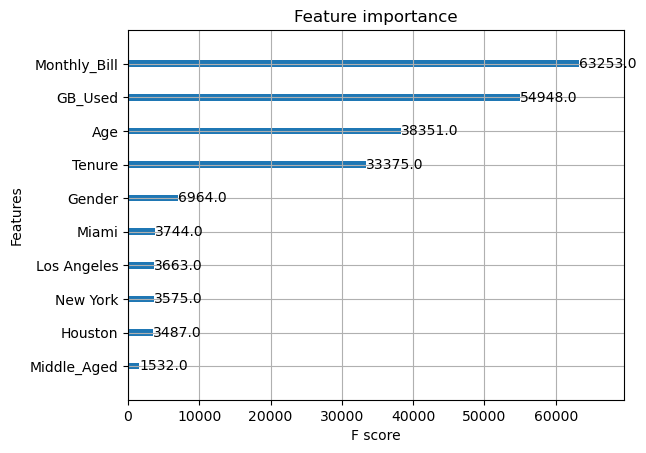

<Figure size 1600x1200 with 0 Axes>

In [46]:
xgboost.plot_importance(xgb2)
plt.figure(figsize = (16, 12))
plt.show()

In [175]:
X1 = X[['Age','Tenure','Monthly_Bill','GB_Used']]

In [176]:
X1_train = X1.iloc[:80000,:]
X1_test = X1.iloc[80000:,:]

In [177]:
print(X1_train.shape)
print(X1_test.shape)

(80000, 4)
(20000, 4)


In [178]:
xgb2.fit(X1_train,y_train, eval_set=[(X1_train,y_train),(X1_test,y_test)], verbose=50)

[0]	validation_0-logloss:0.69308	validation_1-logloss:0.69315
[50]	validation_0-logloss:0.69004	validation_1-logloss:0.69323
[100]	validation_0-logloss:0.68704	validation_1-logloss:0.69326
[107]	validation_0-logloss:0.68662	validation_1-logloss:0.69327


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=70, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [179]:
xgb_pred = xgb2.predict(X1_test)

print(classification_report(y_test,xgb_pred))


              precision    recall  f1-score   support

           0       0.51      0.52      0.51     10079
           1       0.50      0.49      0.49      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



<Axes: >

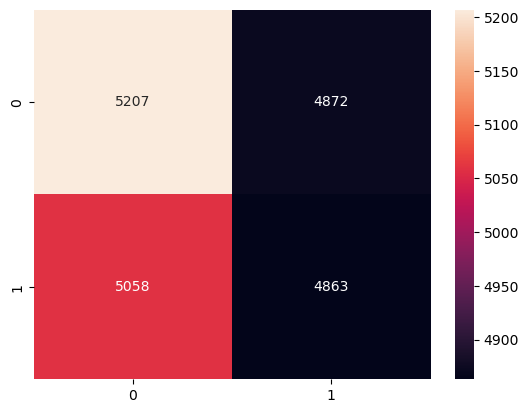

In [59]:
sns.heatmap(confusion_matrix(y_test,xgb_pred), annot=True,fmt='g')

In [52]:
data_dmatrix1 = xgboost.DMatrix(data=X1,label=y)
data_dmatrix1

### Model Deployment

In [189]:
print(X1.shape)
print(y.shape)

(100000, 4)
(100000,)


In [211]:
model = XGBClassifier(**params_xg)
model.fit(X1,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=70, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [213]:
model.score(X1,y)

0.58574

In [199]:
X1.columns

Index(['Age', 'Tenure', 'Monthly_Bill', 'GB_Used'], dtype='object')

In [126]:
df.agg(['min','max'])

,Age,Gender,Location,Tenure,Monthly_Bill,GB_Used,Churn,Age_Group
min,18,0,Chicago,1,30.0,50,0,Young
max,70,1,New York,24,100.0,500,1,Elder


In [218]:
def predict_churn(age, tenure, monthly_bill, gb_used):
    
    input_array = np.array([age, tenure, monthly_bill, gb_used])
    input_array = input_array.reshape(1, -1) 
    age = (age - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
    tenure = (tenure - df['Tenure'].min()) / (df['Tenure'].max() - df['Tenure'].min())
    monthly_bill = (monthly_bill - df['Monthly_Bill'].min()) / (df['Monthly_Bill'].max() - df['Monthly_Bill'].min())
    gb_used = (gb_used - df['GB_Used'].min()) / (df['GB_Used'].max() - df['GB_Used'].min())
    
    return model.predict(input_array)[0]


In [219]:
predict_churn(23,24,100,500)


0